In [89]:
import wandb
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()
sns.set_context('paper')

%matplotlib inline

In [7]:
import os
dump_dir = os.path.abspath('../.log')

def parse_dump(dump):
    ts = dump.get('ts')
#     z0_orig = dump.get('z0_orig')
    true_zt = dump.get('true_zt')
#     true_zt_chaos = dump.get('true_zt_chaos')
    pred_zt = dump.get('pred_zt')

    return ts, true_zt, pred_zt

def download_runs_sweep(run_ids):
    api = wandb.Api()
    for run_id in run_ids:
        download_root = os.path.join(dump_dir, run_id)
        run = api.run("ngruver/physics-uncertainty-exps/{}".format(run_id))
        
        for f in run.files():
            if f.name != 'data.pt' and f.name != 'model.pt':
                continue
        
            fpath = os.path.join(download_root, f.name)
            if not os.path.isfile(fpath):
                f.download(root=download_root)
                
            if f.name == 'data.pt':
                data = torch.load(fpath)
            else:
                model = torch.load(fpath, map_location=torch.device('cpu'))
            
        yield run.name, run.config, model, parse_dump(data)

In [126]:
def compute_rel_error(ref, pred):
    '''
    N is the number of initial conditions.
    M is the number of samples in prediction
    The first dimension "2" corresponds to position + velocity.
    B is the number of bodies.
    The last dimension "2" corresponds to xy.

    Arguments:
        ref: N x T x 2 x B x 2
        pred: M x N x T x 2 x B x 2
    '''
    delta_z = ref.unsqueeze(0) - pred  # M x N x T x 2 x B x 2
    all_err = delta_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    sum_z = ref.unsqueeze(0) + pred  # M x N x T x 2 x B x 2
    pred_rel_err = all_err / sum_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    return pred_rel_err

def compute_geom_mean(ts, values):
    '''Geometric mean of a continuous function over time.
    Arguments:
        ts: T
        values: ... x T
    '''
    t_range = ts.max() - ts.min()
    return torch.trapz((values + 1e-8).log(), ts).div(t_range).exp()  # ...

In [150]:
import os
import sys
import copy
from pprint import pprint

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.models import CHNN
from src.systems.chain_pendulum import ChainPendulum
from src.train.ensemble_trainer import DeepEnsembleTrainer
    
de_run_id = ["1axj7lqk"]

for _, cfg, model_dict, (ts, true_zt, pred_zt) in download_runs_sweep(de_run_id):
    pass

os.environ['DATADIR'] = "/Users/nategruver/Desktop/"
cfg.pop('uq_type')

body = ChainPendulum(cfg.get('num_bodies', 3))
trainer = DeepEnsembleTrainer(**cfg, network=CHNN, body=body)
trainer.train(2)

trainer.model.load_state_dict(model_dict)

In [182]:
preds = trainer.model(true_zt[:,0], ts)

In [183]:
print(preds.size())

torch.Size([5, 25, 334, 2, 3, 2])


In [184]:
num_models, num_init, T, _ , num_bodies, dim = preds.shape

indv_geom_means = []
ens_geom_means = []

for i in range(num_init):
    for k in range(num_bodies):
#         fig, axes = plt.subplots(ncols=2)
        ens_preds = []
        for j in range(num_models):
            y_pred = preds[j, i, :, 0, k, 0]
            y_gt = true_zt[i, :, 0, k, 0]
            error = (y_pred - y_gt).pow(2)
            ens_preds.append(y_pred)
            
#             axes[0].plot(range(T), y_pred, color='red')
#             axes[0].plot(range(T), y_gt, color='black')
        
        ens_preds = torch.stack(ens_preds, 1)
        var = ens_preds.var(1)
        smoothed_grad = scipy.ndimage.gaussian_filter(np.abs(np.gradient(var.numpy())), 5)
#         axes[1].plot(range(T), smoothed_grad)
#         plt.show()
#         plt.close()
        
        lower_grad = 0.001
        upper_grad = 0.02
        
        lower_T = np.where(smoothed_grad < lower_grad)[0]
        upper_T = np.where(smoothed_grad > upper_grad)[0]
        if len(upper_T) == 0:
            continue
        
        lower_T = lower_T[-1]
        upper_T = upper_T[0]
        
        y_pred = preds[:, i:i+1, :, :, k:k+1, :] #lower_T:upper_T, :, k:k+1, :]
        y_gt = true_zt[i:i+1, :, :, k:k+1, :] #lower_T:upper_T, :, k:k+1, :]
        rel_err = compute_rel_error(y_gt, y_pred)[:,0,lower_T:upper_T]
        indv_geom_mean = compute_geom_mean(torch.arange(lower_T, upper_T), rel_err)
        
        rel_err = compute_rel_error(y_gt, y_pred.mean(0))[:,0,lower_T:upper_T]
        ens_geom_mean = compute_geom_mean(torch.arange(lower_T, upper_T), rel_err)
        
        indv_geom_means.append(indv_geom_mean.mean(0).item())
        ens_geom_means.append(ens_geom_mean.item())
        
        print(indv_geom_mean.mean(0).item())
        print(ens_geom_mean.item())

#         fig, axes = plt.subplots(nrows=2)
        
#         for j in range(num_models):
#             y_pred = preds[j, i, :, :, k, :]
#             y_gt = true_zt[i, :, :, k, :]
            
#             axes[0].plot(range(len(y_gt)), y_pred[:,0,0], color='red')
#             axes[0].plot(range(len(y_gt)), y_gt[:,0,0], color='black')
            
#         for j in range(num_models):
#             y_pred = preds[j, i, lower_T:upper_T, :, k, :]
#             y_gt = true_zt[i, lower_T:upper_T, :, k, :]
        
#             axes[1].plot(range(lower_T, upper_T), y_pred[:,0,0], color='red')
#             axes[1].plot(range(lower_T, upper_T), y_gt[:,0,0], color='black')
        
#         plt.show()
#         plt.close()
    
print("\n\n")
print("non-ensemble: {} +- {}".format(np.mean(indv_geom_means), 2 * np.var(indv_geom_means) / 5))
print("ensemble: {} +- {}".format(np.mean(ens_geom_means), 2 * np.var(ens_geom_means) / 5))

0.39210158586502075
0.32528477907180786
0.22736141085624695
0.1433723419904709
0.3624313473701477
0.35473859310150146
0.22199130058288574
0.22387287020683289
0.2920919358730316
0.2526575028896332
0.4592195153236389
0.4402976334095001
0.59264075756073
0.554102897644043
0.3526141047477722
0.34984874725341797
0.19234246015548706
0.14648236334323883
0.2669515907764435
0.20979970693588257
0.3765107989311218
0.3152346909046173
0.2206450253725052
0.1261425018310547
0.2037477046251297
0.1271756887435913
0.08802273124456406
0.05727119743824005
0.13562242686748505
0.04146794229745865
0.17221327126026154
0.10196016728878021
0.17749616503715515
0.08755989372730255
0.19097496569156647
0.16007201373577118
0.13008853793144226
0.11243666708469391
0.11440732330083847
0.08011799305677414
0.4200049340724945
0.34590986371040344
0.5139983892440796
0.5079200267791748
0.272722452878952
0.2444063276052475
0.2189977914094925
0.17067360877990723
0.4726780354976654
0.4158869683742523
0.5122721791267395
0.4825835

0 of 400
1 of 400
2 of 400
3 of 400
4 of 400
5 of 400
6 of 400
7 of 400
8 of 400
9 of 400
10 of 400
11 of 400
12 of 400
13 of 400
14 of 400
15 of 400
16 of 400
17 of 400
18 of 400
19 of 400
20 of 400
21 of 400
22 of 400
23 of 400
24 of 400
25 of 400
26 of 400
27 of 400
28 of 400
29 of 400
30 of 400
31 of 400
32 of 400
33 of 400
34 of 400
35 of 400
36 of 400
37 of 400
38 of 400
39 of 400
40 of 400
41 of 400
42 of 400
43 of 400
44 of 400
45 of 400
46 of 400
47 of 400
48 of 400
49 of 400
50 of 400
51 of 400
52 of 400
53 of 400
54 of 400
55 of 400
56 of 400
57 of 400
58 of 400
59 of 400
60 of 400
61 of 400
62 of 400
63 of 400
64 of 400
65 of 400
66 of 400
67 of 400
68 of 400
69 of 400
70 of 400
71 of 400
72 of 400
73 of 400
74 of 400
75 of 400
76 of 400
77 of 400
78 of 400
79 of 400
80 of 400
81 of 400
82 of 400
83 of 400
84 of 400
85 of 400
86 of 400
87 of 400
88 of 400
89 of 400
90 of 400
91 of 400
92 of 400
93 of 400
94 of 400
95 of 400
96 of 400
97 of 400
98 of 400
99 of 400
100 of 400

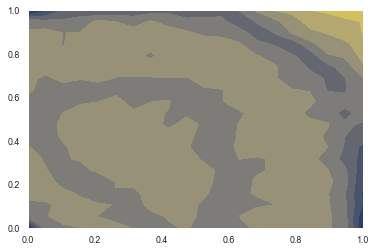

In [108]:
def interpolate_models(models, model_shell, weights):
    state_dict_1 = model_1.state_dict()
    state_dict_2 = model_2.state_dict()
    interp_state_dict = copy.deepcopy(state_dict_1)
#     all_diffs = 0
    for name in interp_state_dict:
        interp_state_dict[name] = torch.zeros_like(interp_state_dict[name]).float()
        for i in range(len(models)):
            interp_state_dict[name] += weights[i] * models[i].state_dict()[name].float()
#         all_diffs += (interp_state_dict[name] - state_dict_1[name]).pow(2).sum()
    model_shell.load_state_dict(interp_state_dict)
    return model_shell
    
models = trainer.model.ensemble[:3]

losses = []
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
xx, yy = np.meshgrid(x, y)
W = np.column_stack([xx.flatten(), yy.flatten()])
last_col = np.ones(len(W)) - np.sum(W, axis=1)
_W = np.concatenate([W, last_col[:,np.newaxis]], axis=1)
W = _W #_W[np.where(_W[:,2] >= 0)[0]]

for idx, weights in enumerate(W):
    print("{} of {}".format(idx, len(W)))
    interp_model = interpolate_models(models, trainer.model.model, weights)
    with torch.no_grad():
        interp_preds = interp_model.integrate(true_zt[:,0], ts, method='rk4')
    loss = (interp_preds - true_zt).pow(2).mean()
#     print(loss)
    losses.append(loss)
    
losses = np.array(losses)
# z = np.zeros(len(_W))
# z[np.where(_W[:,2] >= 0)[0]] = losses
z = losses
z = z.reshape(xx.shape)
    
plt.contourf(x, y, z, cmap='cividis')
plt.show()
plt.close()

In [132]:
print(z)

[[2.837395  4.788486  4.82889   5.0140524 5.0378976 5.0784354 4.9831533
  4.775333  4.9438906 5.0419917 4.8266788 4.7732778 4.882281  5.0853453
  5.2530813 5.0873704 5.165611  5.066018  4.7981863 3.0660293]
 [4.721695  4.907863  5.403916  5.176555  4.997643  4.9056635 4.9575977
  4.8986278 5.045911  5.104867  4.925118  4.9292417 5.000552  5.179969
  5.401049  5.306176  5.0482717 5.1078954 4.65183   3.2079067]
 [4.926519  4.94129   5.098017  5.083661  5.021153  4.9923477 4.8205743
  5.1285973 5.1209555 5.074697  4.9556127 4.8567967 4.769727  4.9386125
  4.997169  5.0742216 5.269732  5.0689106 4.590717  3.4868264]
 [5.123335  5.1707163 5.086403  4.957737  4.8594513 4.9862823 4.858978
  5.237663  5.074603  5.1735997 5.045269  4.867937  4.9270654 5.0294547
  5.059327  5.292498  4.9997764 5.0416794 4.527996  3.463442 ]
 [5.0408697 5.1538863 4.87279   4.9945316 4.737332  5.0140514 5.156766
  5.485654  5.287457  5.1995916 5.0890093 4.9097147 4.7313175 5.096582
  5.0270276 5.159046  5.0818114 

traj-wise: 0.14198407530784607 +- 0.018076948821544647
state-wise: 0.16455717384815216 +- 0.016635920107364654


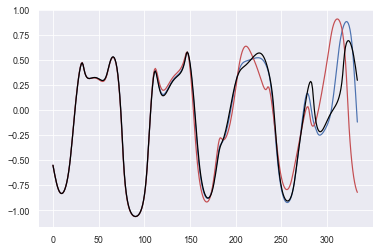

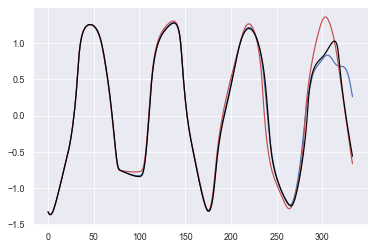

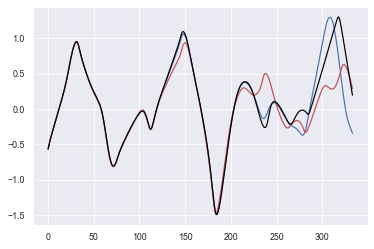

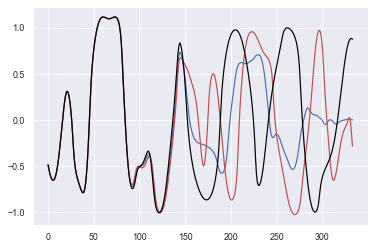

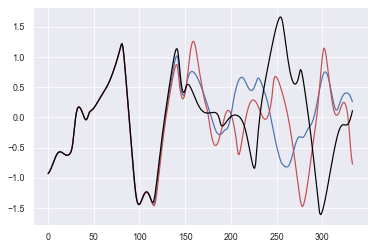

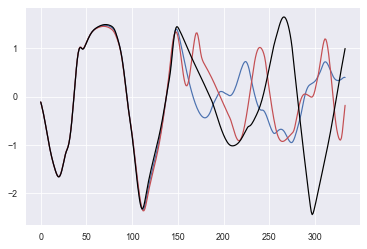

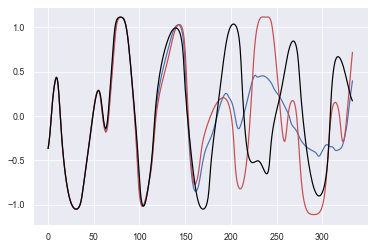

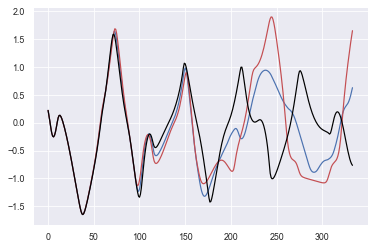

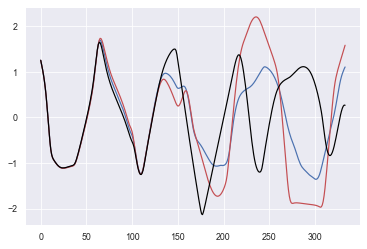

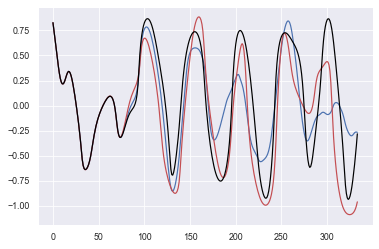

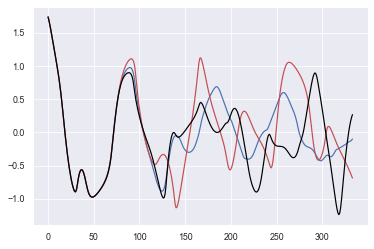

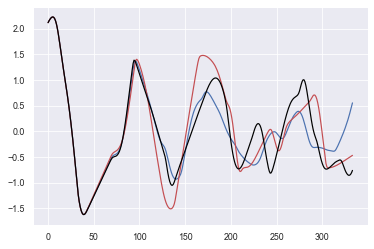

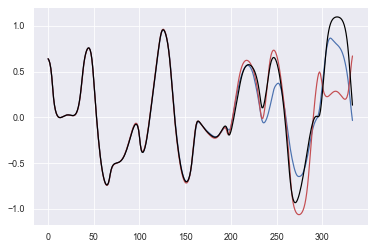

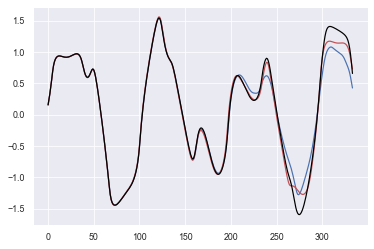

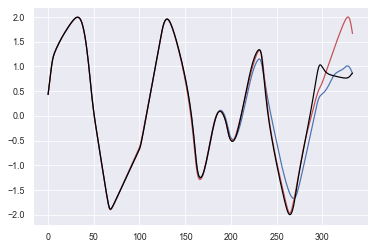

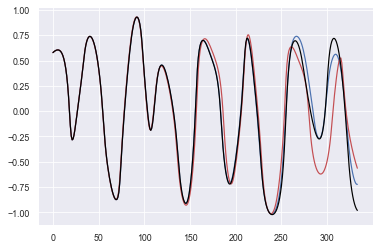

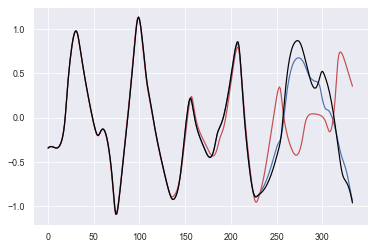

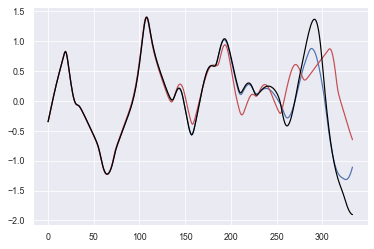

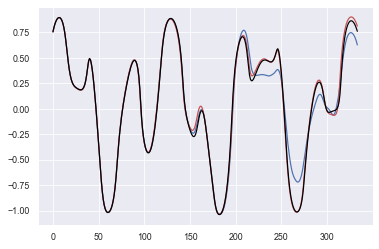

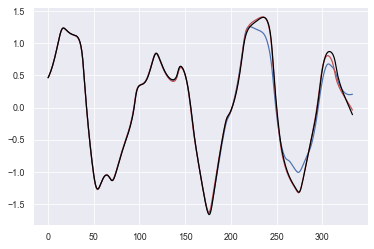

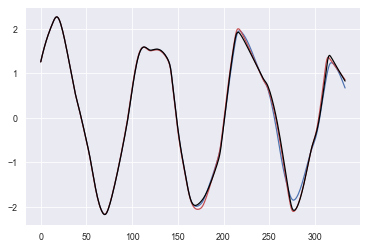

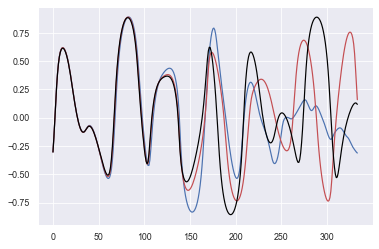

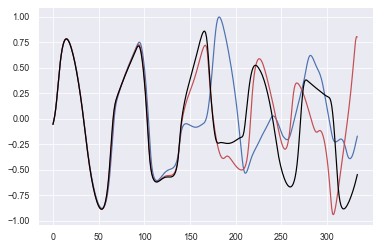

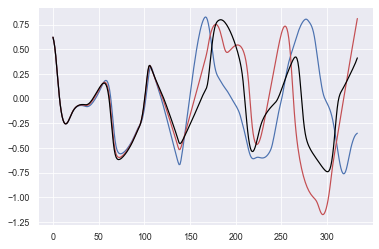

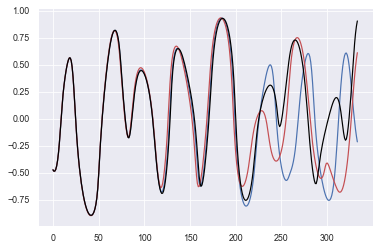

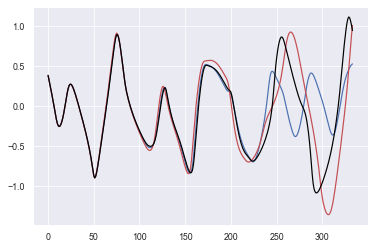

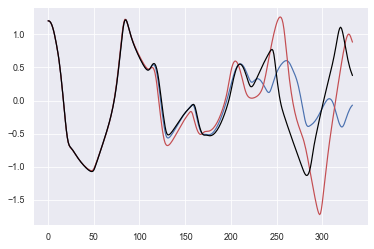

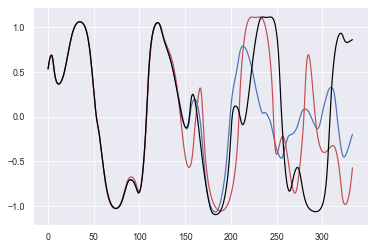

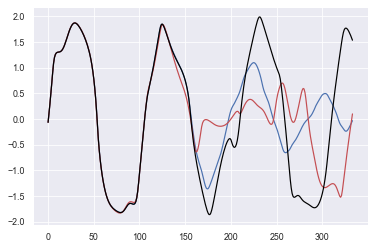

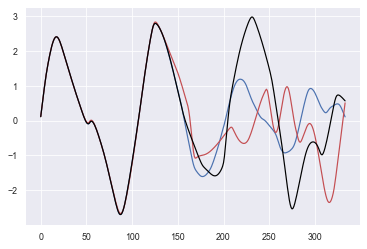

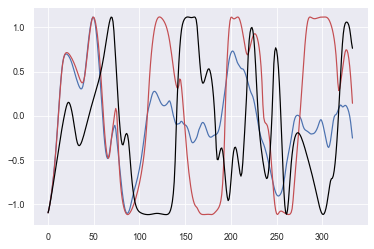

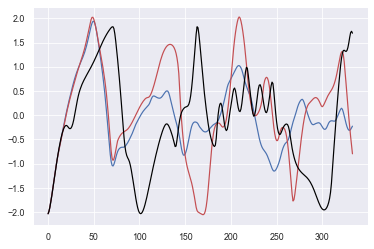

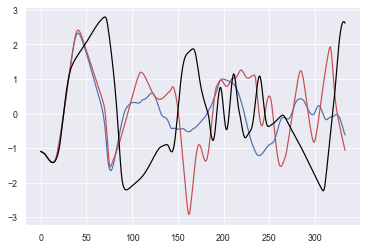

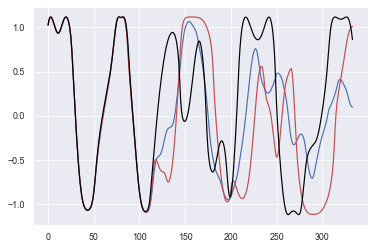

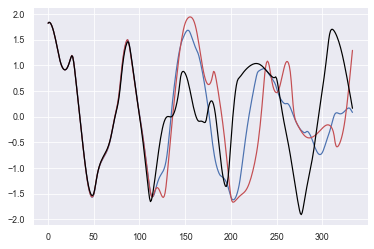

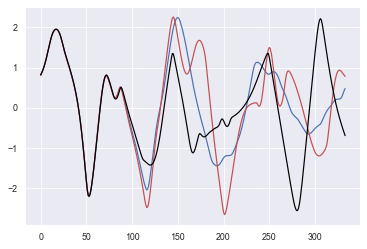

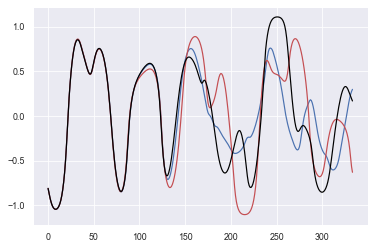

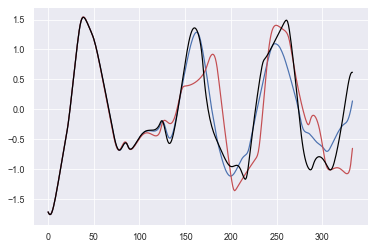

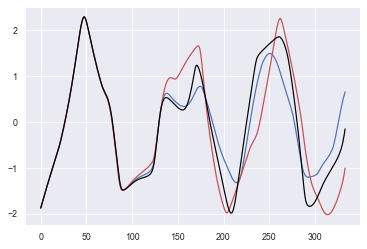

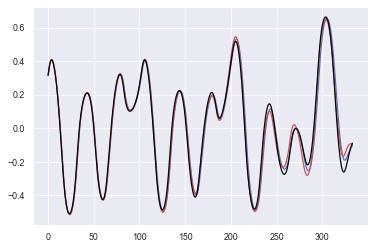

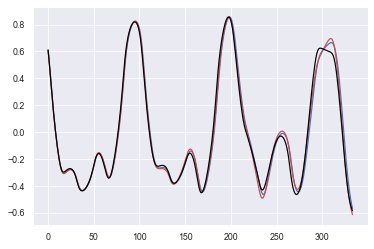

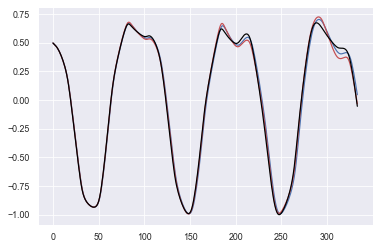

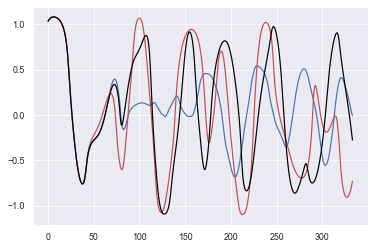

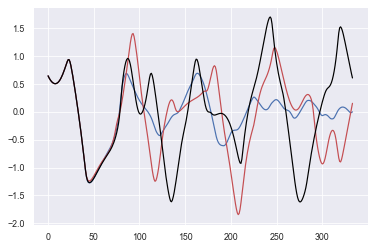

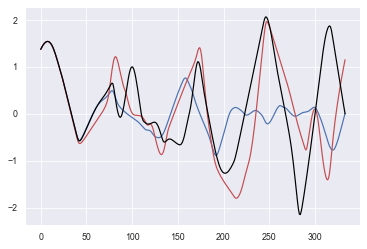

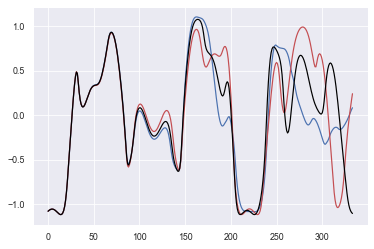

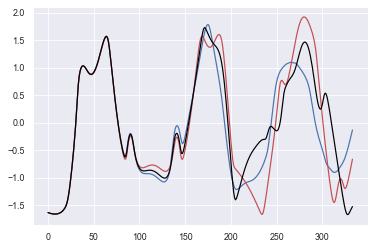

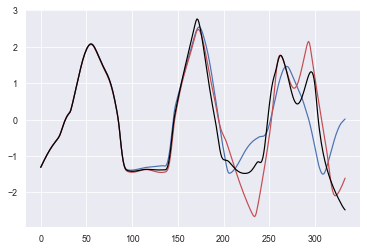

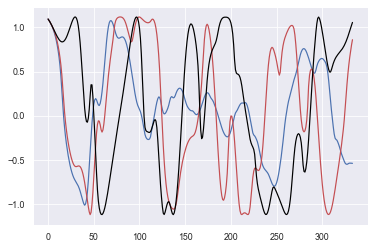

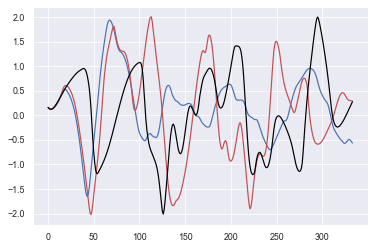

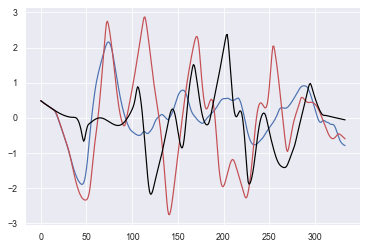

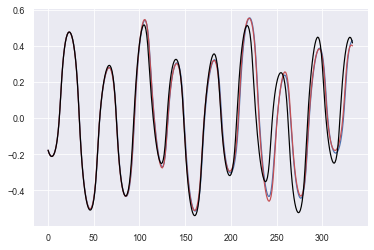

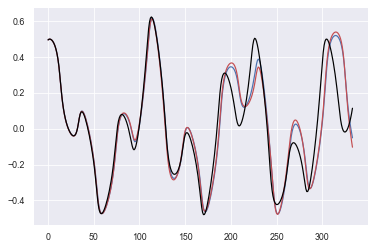

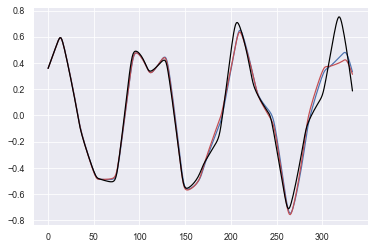

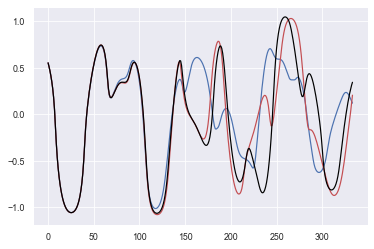

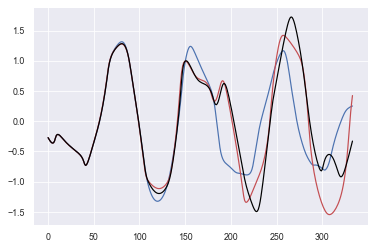

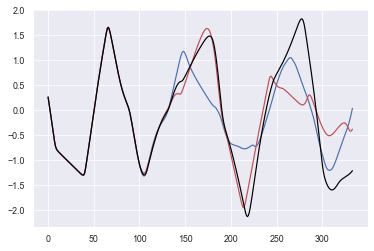

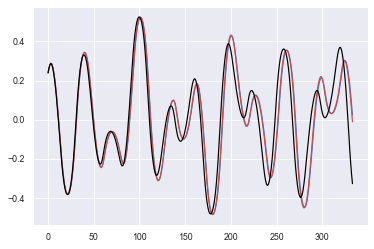

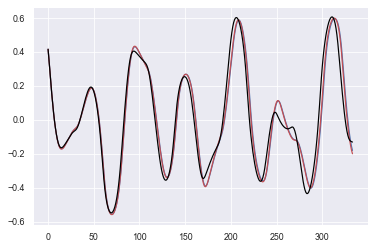

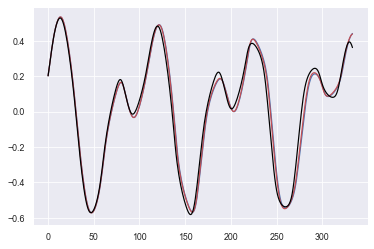

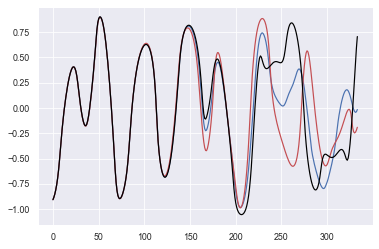

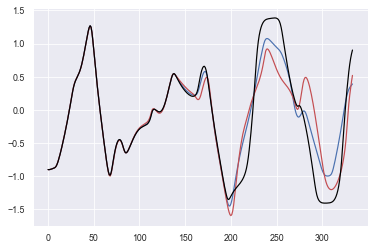

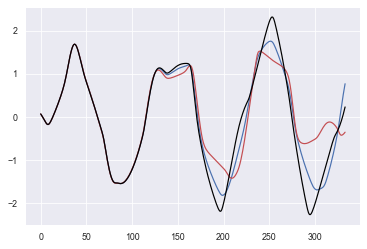

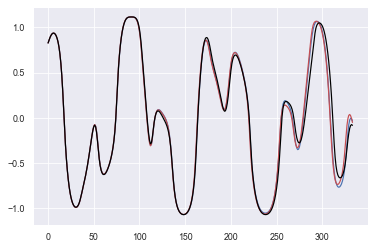

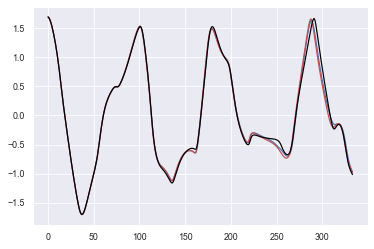

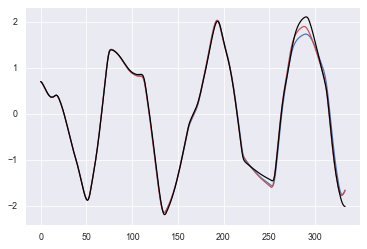

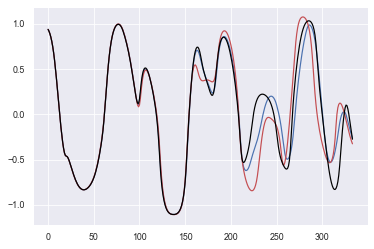

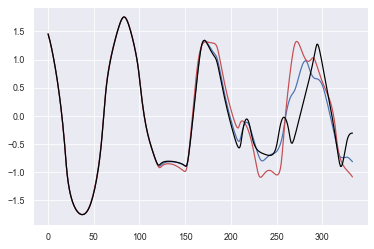

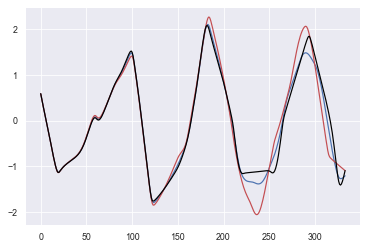

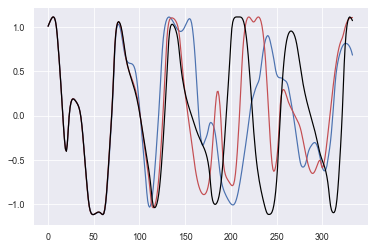

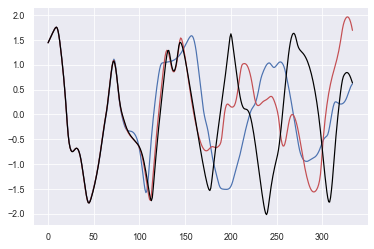

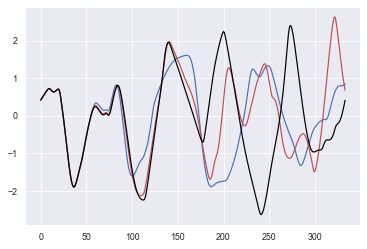

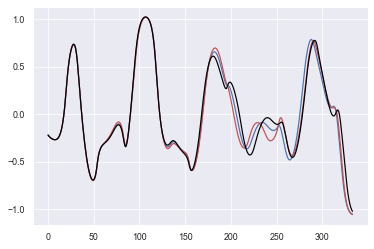

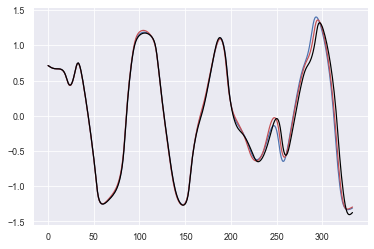

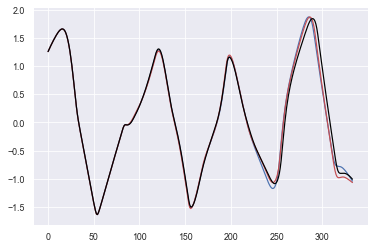

In [185]:
de_run_id = ["1axj7lqk"]
for _, cfg, model_dict, (ts, true_zt, pred_zt) in download_runs_sweep(de_run_id):
    pass

rel_err = compute_rel_error(true_zt, pred_zt.mean(0))
geom_mean = compute_geom_mean(ts, rel_err)

print("traj-wise: {} +- {}".format(geom_mean.mean().item(), 2 * geom_mean.var().item() / 5))

de_run_id = ["1hwu7aab"]
for _, cfg, model_dict, (ts, true_zt, pred_zt_step) in download_runs_sweep(de_run_id):
    pass

rel_err = compute_rel_error(true_zt, pred_zt_step)
geom_mean = compute_geom_mean(ts, rel_err)

print("state-wise: {} +- {}".format(geom_mean.mean().item(), 2 * geom_mean.var().item() / 5))

for i in range(num_init):
    for k in range(num_bodies):
        y_pred = pred_zt[:, i, :, 0, k, 0].mean(0)
        y_pred_step = pred_zt_step[0, i, :, 0, k, 0]
        y_gt = true_zt[i, :, 0, k, 0]
        
        plt.plot(range(len(y_gt)), y_pred, color='b')
        plt.plot(range(len(y_gt)), y_pred_step, color='r')
        plt.plot(range(len(y_gt)), y_gt, color='black')
        plt.show()
        plt.close()